# **Day 4: Unsupervised Learning for Phising Detection**

 ## Install Dependencies

In [1]:
# !pip install gensim pytorch-lightning joblib
# !python -m spacy download en_core_web_md
# !pip install numpy==1.24.4 pandas==1.5.3

## Import Libraries

In [2]:
# Data handling
import pandas as pd                                     # For DataFrame operations and data manipulation
import numpy as np                                      # For numerical operations and array handling
import joblib                                           # For saving/loading models and preprocessing objects

# Model selection and evaluation metrics
from sklearn.ensemble import IsolationForest            # For anomaly detection model
from sklearn.metrics import (                           # Metrics & confusion matrix
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import LabelEncoder          # To encode categorical labels as integers

# Natural Language Processing (NLP)
import spacy                                            # Advanced NLP tasks (tokenization, POS tagging, etc.)
from gensim.models import Word2Vec                      # To create word embeddings from text data
from gensim.utils import tokenize as gensim_tokenize    # Tokenizer utility from gensim
from nltk.corpus import stopwords                       # To remove common stopwords during text preprocessing
import re                                               # Regular expressions for text cleaning

# Deep Learning with PyTorch and PyTorch Lightning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl                          # High-level PyTorch training framework

# Progress bar
from tqdm.notebook import tqdm                          # For progress bars in notebooks

# Kaggle utilities
import kagglehub                                        # Utility for Kaggle dataset handling

# Visualization
import matplotlib.pyplot as plt                         # For plotting graphs and charts


## Import Data

In [3]:
# Download latest version
path = kagglehub.dataset_download("subhajournal/phishingemails")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\subhajournal\phishingemails\versions\1


In [4]:
df = pd.read_csv(f"{path}\Phishing_Email.csv", index_col=0)
df

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email
...,...,...
18646,date a lonely housewife always wanted to date ...,Phishing Email
18647,request submitted : access request for anita ....,Safe Email
18648,"re : important - prc mtg hi dorn & john , as y...",Safe Email
18649,press clippings - letter on californian utilit...,Safe Email


## Data Cleaning and Preprocessing

In [5]:
def preprocess_text(text):
    # Handle NaN values
    if pd.isna(text):
        return ""

    # Remove numbers (if desired)
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()

    return text

def count_urls(text):
    if pd.isna(text):
        return 0
    # Regex pattern for finding URLs
    url_pattern = r'(https?://\S+|www\.\S+)'
    return len(re.findall(url_pattern, text))

# We define a new feature `url_count` that captures the number of URLs present in each email.
# This feature may help identify patterns in spam or phishing emails, which often contain links.
# Count URLs before preprocessing (just in case preprocessing removes them)
df['url_count'] = df['Email Text'].apply(count_urls)

df['Email Text'] = df['Email Text'].apply(preprocess_text)

# Filter out rows with 'Email Text' length > 50,000
# NOTE: Some email texts are extremely long (more than 50,000 characters), and those can take a
#       lot of time to process and embed. To speed things up and avoid potential slowdowns or
#       crashes, we’ll filter them out and only keep emails with text length ≤ 50,000.
df = df[df['Email Text'].str.len() <= 50000]

df

,Email Text,Email Type,url_count
0,re disc uniformitarianism re sex lang ...,Safe Email,0
1,the other side of galicismos galicismo is ...,Safe Email,0
2,re equistar deal tickets are you still availa...,Safe Email,0
3,hello i am your hot lil horny toy i am the one...,Phishing Email,1
4,software at incredibly low prices lower dr...,Phishing Email,0
...,...,...,...
18646,date a lonely housewife always wanted to date ...,Phishing Email,0
18647,request submitted access request for anita d...,Safe Email,0
18648,re important prc mtg hi dorn john as you d...,Safe Email,0
18649,press clippings letter on californian utiliti...,Safe Email,0


## Text Representation

The two cells below each generate email embeddings (numerical vector representations of the email text), but **using different methods**:

- ##### 1. **Word2Vec-based Embeddings** (First Cell)
    - Trains a Word2Vec model using your dataset.
    - Creates email vectors by averaging the word vectors from your custom-trained model.

- ##### 2. **spaCy Pre-trained Embeddings** (Second Cell)
    - Uses the pre-trained `en_core_web_md` model from spaCy.
    - Creates email vectors by averaging the pre-trained word vectors of meaningful words in the email.

<i>**Uncomment and use only one of these cells at a time.**  
If you'd like to explore the other embedding method, **comment out the one you used, uncomment the other, and re-run the notebook.** <i>

In [6]:
def tokenize_text(text):
    """
    Clean and break the email into tokens
    """
    # gensim_tokenize turns text into a list of words
    # lowercase=True makes everything lowercase (e.g., "Email" becomes "email")
    # deacc=True removes special accents from characters
    return list(gensim_tokenize(text, lowercase=True, deacc=True))  # deacc=True removes accents

# Apply the tokenize function to every email in the dataset
# This gives us a list of lists, where each inner list is the tokenized version of an email
tokenized_emails = [tokenize_text(email) for email in df['Email Text']]

# Train a Word2Vec model using the tokenized emails
# Word2Vec learns a vector (a list of numbers) for each word based on the words it appears near
word2vec_model = Word2Vec(
    sentences=tokenized_emails,     # Training data
    vector_size=100,                # Each word will be represented by a 100-length vector
    window=3,                       # How many words to look at around each word (context window)
    min_count=1,                    # Include all words, even if they appear only once
    workers=4                       # Use 4 CPU cores to train faster
)

def email_to_word2vec_vector(email_text):
    """
    Converts an email into a single vector by averaging the word vectors
    """
    # Split the email into words
    words = tokenize_text(email_text)

    # Start with a zero vector
    vector = np.zeros(word2vec_model.vector_size)

    # Keep traack of how many words we actually used
    valid_word_count = 0
    for word in words:
        # Check if the word has a learned vector
        if word in word2vec_model.wv:
            # Add the word's vector to the total
            vector += word2vec_model.wv[word]
            valid_word_count += 1

    # If none of the words had vectors, return a zero vector
    if valid_word_count == 0:
        return np.zeros(word2vec_model.vector_size)

    # Otherwise, return the average vector
    return vector / valid_word_count

# Apply the function to all emails and store the resulting vectors in a new column
df['Email Vector'] = df['Email Text'].apply(email_to_word2vec_vector)

df

C:\Users\user\AppData\Local\Temp\ipykernel_9924\1509455371.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Email Vector'] = df['Email Text'].apply(email_to_word2vec_vector)


,Email Text,Email Type,url_count,Email Vector
0,re disc uniformitarianism re sex lang ...,Safe Email,0,"[-0.16430931909408952, 0.9659628435011421, -0...."
1,the other side of galicismos galicismo is ...,Safe Email,0,"[-0.33367560843838223, 1.0881643842491928, -0...."
2,re equistar deal tickets are you still availa...,Safe Email,0,"[0.10617183730046932, 0.7205482646212226, -0.2..."
3,hello i am your hot lil horny toy i am the one...,Phishing Email,1,"[-0.11909409235243963, 0.9913654729248361, -0...."
4,software at incredibly low prices lower dr...,Phishing Email,0,"[-0.2779060901061351, 0.5590009300540837, -0.1..."
...,...,...,...,...
18646,date a lonely housewife always wanted to date ...,Phishing Email,0,"[-0.4692269823087069, 0.6483846351038665, -0.3..."
18647,request submitted access request for anita d...,Safe Email,0,"[-0.2135008086190849, 1.1228559518568828, -0.4..."
18648,re important prc mtg hi dorn john as you d...,Safe Email,0,"[-0.17266878905563868, 1.1607748042508421, -0...."
18649,press clippings letter on californian utiliti...,Safe Email,0,"[-0.5401737365800028, 0.8006029619763677, -0.3..."


In [7]:
# # Load spaCy's medium English language model that includes pre-trained word vectors
# # These vectors help us turn words into numbers, so we can use them in machine learning
# nlp = spacy.load("en_core_web_md")

# # This list will store the final numerical vector for each email
# vectors = []

# # Use tqdm to show progress as spaCy processes the emails
# # nlp.pipe allows processing texts faster by using multiple cores (n_process=4)
# # batch_size=128 means spaCy processes 128 emails at a time
# for doc in tqdm(nlp.pipe(df['Email Text'], batch_size=128, n_process=4), total=len(df)):
#     # For each email (doc), go through every word (token)
#     # We use the lemma (base form) of each word instead of the original word to group similar forms together (e.g., "running" → "run")
#     # We keep only tokens that:
#     # - have a pre-trained word vector available,
#     # - are not stopwords (common words like "and", "the" that usually don't add meaning),
#     # - and are not punctuation marks
#     vecs = [
#         nlp.vocab[token.lemma_].vector
#         for token in doc
#         if token.has_vector and not token.is_stop and not token.is_punct
#     ]

#     if vecs:
#         # If the email had valid word vectors, take the average of all word vectors to represent the entire email
#         vectors.append(np.mean(vecs, axis=0))
#     else:
#         # If the email had no valid vectors (very rare), just use a vector of zeros
#         vectors.append(np.zeros(nlp.vocab.vectors_length))

# # Add the computed email vectors as a new column in the original dataframe
# df['Email Vector'] = vectors

# df

## Model Normal VS Anomalous Behaviour

In [8]:
X_test = np.vstack(df['Email Vector'].values)

# NOTE: In this notebook, we are only using the email vectors and url counts as features. No
#       other features (like numerical or categorical ones) have been included yet.

# OPTIONAL: If you want to include more features in the future, make sure to first concatenate
#           them to the dataframe (df), and then uncomment the lines below to merge them into
#           the final feature matrix.

# extra_features = df[["feature1", "feature2"]].values
extra_features = df[["url_count"]].values # Example of an additional feature

X_test = np.hstack([X_test, extra_features])

# Now, X_test includes both the email vector representation and the additional features (if provided)
X_test

array([[-0.16430932,  0.96596284, -0.5240289 , ..., -0.3559903 ,
         0.26911269,  0.        ],
       [-0.33367561,  1.08816438, -0.53589214, ..., -0.05992974,
         0.4495218 ,  0.        ],
       [ 0.10617184,  0.72054826, -0.23823255, ..., -0.27021611,
        -0.22398887,  0.        ],
       ...,
       [-0.17266879,  1.1607748 , -0.46576043, ..., -0.51603405,
         0.37297571,  0.        ],
       [-0.54017374,  0.80060296, -0.31365913, ..., -0.45734816,
         0.0098875 ,  0.        ],
       [-0.19877058,  0.2477655 , -0.09501535, ...,  0.49520567,
        -0.16802254,  0.        ]])

In [9]:
from sklearn.ensemble import IsolationForest

# Create the Isolation Forest model
# contamination=0.1 means we expect about 10% of the data to be anomalies (phishing emails)
# random_state is set so that the results are consistent every time we run the code
isof_model = IsolationForest(contamination=0.1, random_state=2025)

# Fit the model on the test data and predict which points are anomalies
# It returns -1 for anomalies (phishing) and 1 for normal points (safe emails)
Y_test = isof_model.fit_predict(X_test)

# Make a copy of the original dataframe so we can add predictions to it without changing the original
isolationforest_df = df.copy()

# Add a new column with the predicted labels
# If the model predicted -1, it's a phishing email
# If the model predicted 1, it's a safe email
isolationforest_df['Predicted Email Type'] = np.where(Y_test == -1, "Phishing Email", "Safe Email")

isolationforest_df

,Email Text,Email Type,url_count,Email Vector,Predicted Email Type
0,re disc uniformitarianism re sex lang ...,Safe Email,0,"[-0.16430931909408952, 0.9659628435011421, -0....",Safe Email
1,the other side of galicismos galicismo is ...,Safe Email,0,"[-0.33367560843838223, 1.0881643842491928, -0....",Safe Email
2,re equistar deal tickets are you still availa...,Safe Email,0,"[0.10617183730046932, 0.7205482646212226, -0.2...",Safe Email
3,hello i am your hot lil horny toy i am the one...,Phishing Email,1,"[-0.11909409235243963, 0.9913654729248361, -0....",Safe Email
4,software at incredibly low prices lower dr...,Phishing Email,0,"[-0.2779060901061351, 0.5590009300540837, -0.1...",Safe Email
...,...,...,...,...,...
18646,date a lonely housewife always wanted to date ...,Phishing Email,0,"[-0.4692269823087069, 0.6483846351038665, -0.3...",Safe Email
18647,request submitted access request for anita d...,Safe Email,0,"[-0.2135008086190849, 1.1228559518568828, -0.4...",Safe Email
18648,re important prc mtg hi dorn john as you d...,Safe Email,0,"[-0.17266878905563868, 1.1607748042508421, -0....",Safe Email
18649,press clippings letter on californian utiliti...,Safe Email,0,"[-0.5401737365800028, 0.8006029619763677, -0.3...",Safe Email


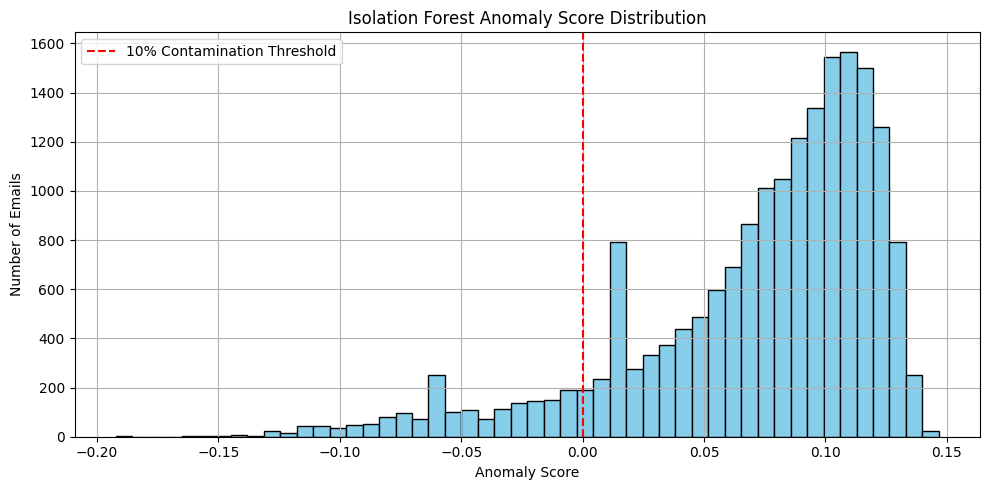

In [10]:
# Returns the anomaly score for each sample
# Higher score = more "normal"
isof_scores = isof_model.decision_function(X_test)

# Plot the distribution of scores across all emails
plt.figure(figsize=(10, 5))
plt.hist(isof_scores, bins=50, color='skyblue', edgecolor='black')

# Anything to the left of this line is predicted as an anomaly
plt.axvline(np.percentile(isof_scores, 10), color='red', linestyle='--', label='10% Contamination Threshold')

plt.title('Isolation Forest Anomaly Score Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Number of Emails')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Most emails have higher scores (to the right → more normal). A long tail to the left contains emails with low scores (anomalies). This is a good sign: you're seeing a clear separation between common (safe) and rare (possibly phishing) patterns.



In [11]:
# ----------------- Define AutoEncoder Model -----------------

class AutoEncoder(pl.LightningModule):
    """
    This class creates an autoencoder — a special type of neural network that learns
    how to "compress" data into a smaller size, and then "rebuild" it.

    - Encoder: Makes the input smaller (compression).
    - Decoder: Rebuilds the original input from the compressed version.
    """

    def __init__(self, input_size, compressed_size, hidden_divisor=4, activation=nn.ReLU()):
        super().__init__()

        self.compressed_size = compressed_size
        # To be set after training
        self.threshold = None

        # This defines the number of neurons in the middle hidden layer
        hidden_size = (input_size + compressed_size) // hidden_divisor

        # Define the encoder: shrinks input -> hidden -> compressed layer
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            activation,
            nn.Linear(hidden_size, compressed_size),
            activation,
        )

        # Define the decoder: expands compressed -> hidden -> original size
        self.decoder = nn.Sequential(
            nn.Linear(compressed_size, hidden_size),
            activation,
            nn.Linear(hidden_size, input_size),
        )

    def forward(self, x):
        """
        Forward pass:
        Take input data, compress it, then try to reconstruct it.
        """
        compressed = self.encoder(x)
        reconstructed = self.decoder(compressed)
        return reconstructed

    def training_step(self, batch, batch_idx):
        """
        Runs one training step. It compares the input to its reconstruction and calculates how far
        off they are (using Mean Squared Error).
        """
        inputs = batch[0]  # unpack the batch (no labels in unsupervised)
        inputs = inputs.view(inputs.size(0), -1)  # flatten if needed
        outputs = self(inputs)
        loss = F.mse_loss(outputs, inputs)  # mean squared error loss between input and reconstruction
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        """
        Defines the optimizer to use during training.
        Currently using Adam with a learning rate of 0.001.
        """
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# ----------- Prepare data ------------

# Convert NumPy array (X_test) into a PyTorch tensor for the model
inputs_tensor = torch.tensor(X_test, dtype=torch.float32)

# Wrap the tensor in a dataset and a DataLoader to enable batch training
dataset = TensorDataset(inputs_tensor)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# ----------- Initialize and train model ------------

input_dim = X_test.shape[1]     # Number of features
compressed_dim = 32             # Size of compressed representation; We want to shrink to 32 features

# Create the autoencoder model instance
autoencoder_model = AutoEncoder(input_size=input_dim, compressed_size=compressed_dim)

# Initialize the PyTorch Lightning trainer (set max epochs and logging frequency)
# Set up the trainer to run for 20 passes through the data
trainer = pl.Trainer(max_epochs=20, log_every_n_steps=5, logger=False)

# Train the model using the DataLoader
trainer.fit(autoencoder_model, train_dataloaders=data_loader)


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\user\anaconda3\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory c:\Users\user\OneDrive\Desktop\New folder\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 4.5 K  | train
1 | decoder | Sequential | 4.5 K  | train
-----------------------------------------------
9.0 K     Trainable params
0         Non-trainable params
9.0 K     Total params
0.036     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
c:\Users\user\anaconda3\Lib\site-packages\pytorch_lightning\trainer\conne

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [12]:
# ----------- Get reconstruction and calculate errors ------------

# Put the model in evaluation mode (turns off dropout, batchnorm, etc.)
autoencoder_model.eval()

# Disable gradient calculations to speed up computation and save memory during inference
with torch.no_grad():
    # Reconstruct the inputs using the trained model
    reconstructed_inputs = autoencoder_model(inputs_tensor)

# Calculate how different each email is from its reconstruction
# This is the reconstruction error (lower is better)
reconstruction_errors = F.mse_loss(reconstructed_inputs, inputs_tensor, reduction='none').mean(dim=1)

print(f"Mean reconstruction error: {reconstruction_errors.mean().item():.6f}")
print(f"Std deviation of error: {reconstruction_errors.std().item():.6f}")
print(f"95th percentile error threshold: {torch.quantile(reconstruction_errors, 0.95).item():.6f}")


Mean reconstruction error: 0.008696
Std deviation of error: 0.015931
95th percentile error threshold: 0.024155


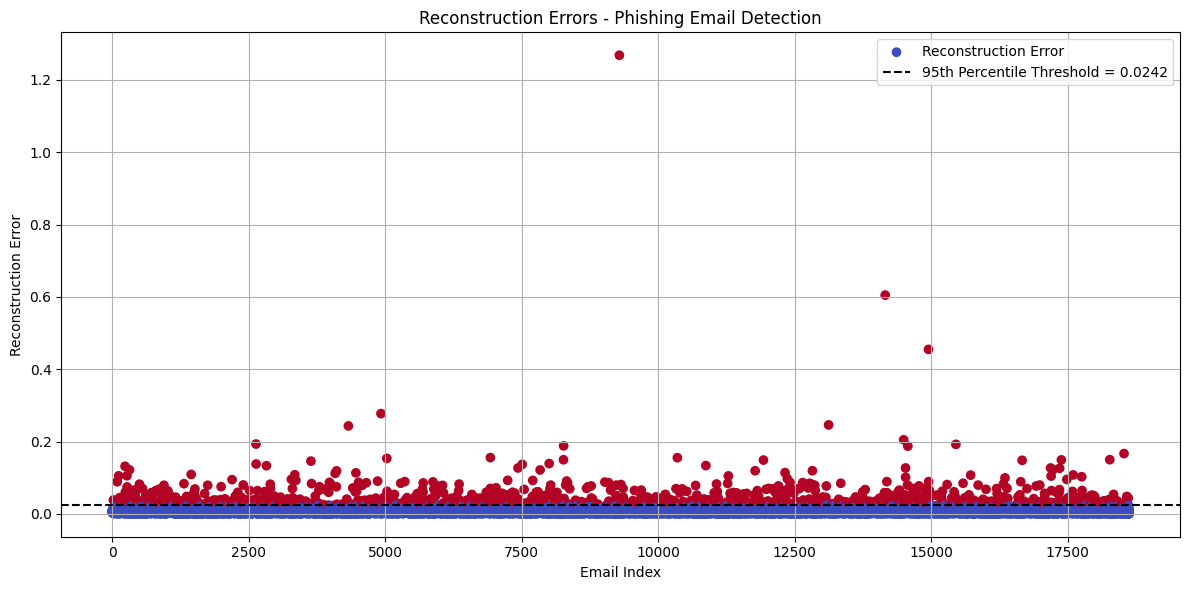

In [13]:
# Convert reconstruction errors to NumPy array for plotting
errors = reconstruction_errors.numpy()

# Determine the error threshold for flagging an email as phishing (top 5% of errors)
threshold = torch.quantile(reconstruction_errors, 0.95).item()

# Save the threshold value to the model instance
autoencoder_model.threshold = threshold

# Create a True/False list — True if error > threshold
is_phishing = errors > threshold

# Plot the errors and highlight the phishing emails
plt.figure(figsize=(12, 6))
plt.scatter(np.arange(len(errors)), errors, c=is_phishing, cmap='coolwarm', label='Reconstruction Error')
plt.axhline(y=threshold, color='black', linestyle='--', label=f'95th Percentile Threshold = {threshold:.4f}')

plt.title('Reconstruction Errors - Phishing Email Detection')
plt.xlabel('Email Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Autoencoder is trained to reconstruct inputs (email vectors). It learns to compress and reconstruct common patterns (normal emails). When given an unusual email (like phishing), it can't reconstruct it well, so Reconstruction error is high. We can set a threshold (like the 95th percentile) and call anything above that "anomaly"

In [14]:
# ----------------- Mark Emails as Phishing or Safe -----------------

# Create a mask that marks emails as phishing if their reconstruction error exceeds the threshold
is_phishing = reconstruction_errors > autoencoder_model.threshold

# Make a copy of the original dataframe so we can add predictions to it without changing the original
autoencoder_df = df.copy()

# Add a new column with the predicted labels
autoencoder_df['Predicted Email Type'] = ['Phishing Email' if flagged else 'Safe Email' for flagged in is_phishing.numpy()]

autoencoder_df

,Email Text,Email Type,url_count,Email Vector,Predicted Email Type
0,re disc uniformitarianism re sex lang ...,Safe Email,0,"[-0.16430931909408952, 0.9659628435011421, -0....",Safe Email
1,the other side of galicismos galicismo is ...,Safe Email,0,"[-0.33367560843838223, 1.0881643842491928, -0....",Safe Email
2,re equistar deal tickets are you still availa...,Safe Email,0,"[0.10617183730046932, 0.7205482646212226, -0.2...",Safe Email
3,hello i am your hot lil horny toy i am the one...,Phishing Email,1,"[-0.11909409235243963, 0.9913654729248361, -0....",Safe Email
4,software at incredibly low prices lower dr...,Phishing Email,0,"[-0.2779060901061351, 0.5590009300540837, -0.1...",Safe Email
...,...,...,...,...,...
18646,date a lonely housewife always wanted to date ...,Phishing Email,0,"[-0.4692269823087069, 0.6483846351038665, -0.3...",Safe Email
18647,request submitted access request for anita d...,Safe Email,0,"[-0.2135008086190849, 1.1228559518568828, -0.4...",Safe Email
18648,re important prc mtg hi dorn john as you d...,Safe Email,0,"[-0.17266878905563868, 1.1607748042508421, -0....",Safe Email
18649,press clippings letter on californian utiliti...,Safe Email,0,"[-0.5401737365800028, 0.8006029619763677, -0.3...",Safe Email


## Model Evaluation

In a true unsupervised situation, we don’t have any labels or answers to check if our model is doing a good job. So, what we can do is:
- Take a small random sample of the model’s predictions,
- Check those samples ourselves and decide if they are right or wrong (this is called manually labeling),
- Use these checked samples to construct our confusion matrix and see how well the model did (which helps us understand mistakes and successes).

But, since we actually have the labels already in this case, we can just use those to create the confusion matrix and easily check how well our model works.

In [15]:
# Import LabelEncoder to turn categories (like 'phishing' or 'safe') into numbers
class_labels = ["Safe Email", "Phishing Email"]
le = LabelEncoder()
le.fit(class_labels)

LabelEncoder()

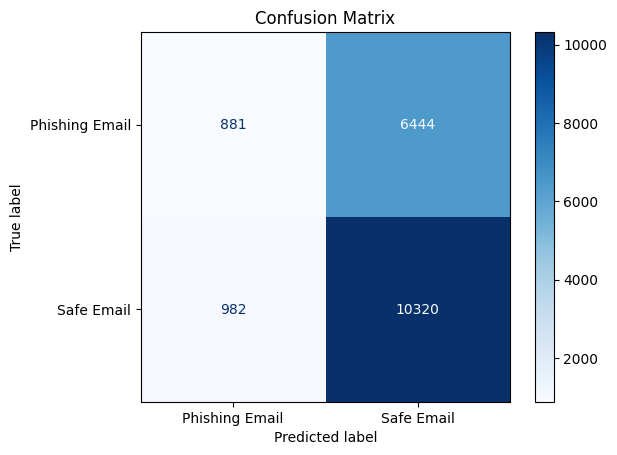

Accuracy : 0.6013
Precision: 0.6156
Recall   : 0.9131
F1 Score : 0.7354


In [16]:
# Convert the true email labels (what the emails really are) into numbers
isof_y_true = le.transform(isolationforest_df['Email Type'])

# Convert the predicted email labels (what the model guessed) into numbers
isof_y_pred = le.transform(isolationforest_df['Predicted Email Type'])

# Create a confusion matrix that shows how many emails were correctly or wrongly classified
isof_cm = confusion_matrix(isof_y_true, isof_y_pred)


# ----------------- Confusion Matrix -----------------

# Set up a way to display the confusion matrix with the actual labels shown
disp = ConfusionMatrixDisplay(confusion_matrix=isof_cm, display_labels=le.classes_)
# Show the confusion matrix as a colored grid with numbers
disp.plot(cmap='Blues', values_format='d')
# Add a title to the plot so we know what it is
plt.title("Confusion Matrix")
# Display the plot on the screen
plt.show()

# Calculate evaluation metrics
accuracy = accuracy_score(isof_y_true, isof_y_pred)
precision = precision_score(isof_y_true, isof_y_pred)
recall = recall_score(isof_y_true, isof_y_pred)
f1 = f1_score(isof_y_true, isof_y_pred)

# Display results
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


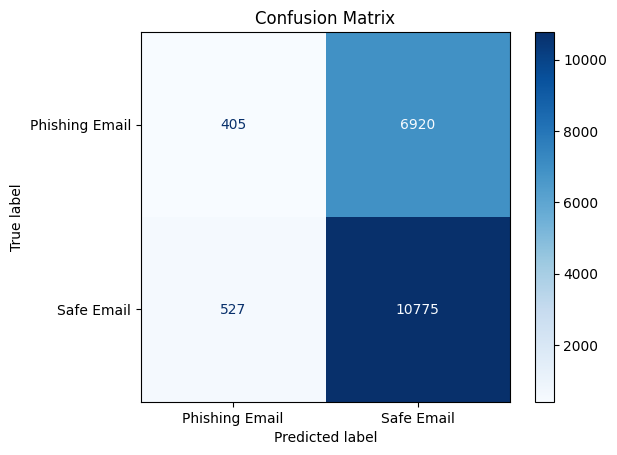

Accuracy : 0.6002
Precision: 0.6089
Recall   : 0.9534
F1 Score : 0.7432


In [17]:
# Convert the true email labels (what the emails really are) into numbers
autoencoder_y_true = le.transform(autoencoder_df['Email Type'])

# Convert the predicted email labels (what the model guessed) into numbers
autoencoder_y_pred = le.transform(autoencoder_df['Predicted Email Type'])


# ----------------- Confusion Matrix -----------------

# Create a confusion matrix that shows how many emails were correctly or wrongly classified
autoencoder_cm = confusion_matrix(autoencoder_y_true, autoencoder_y_pred)
# Set up a way to display the confusion matrix with the actual labels shown
disp = ConfusionMatrixDisplay(confusion_matrix=autoencoder_cm, display_labels=le.classes_)
# Show the confusion matrix as a colored grid with numbers
disp.plot(cmap='Blues', values_format='d')
# Add a title to the plot so we know what it is
plt.title("Confusion Matrix")
# Display the plot on the screen
plt.show()

# Calculate evaluation metrics
accuracy = accuracy_score(autoencoder_y_true, autoencoder_y_pred)
precision = precision_score(autoencoder_y_true, autoencoder_y_pred)
recall = recall_score(autoencoder_y_true, autoencoder_y_pred)
f1 = f1_score(autoencoder_y_true, autoencoder_y_pred)

# Display results
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

Let's compare how two different models — Isolation Forest and Autoencoder — did at finding phishing emails.
- Accuracy tells us how many emails the model got right overall.
- Precision tells us, out of all the emails the model said were phishing, how many really were phishing.
- Recall tells us, out of all the actual phishing emails, how many the model successfully found.
- F1 Score is a balance between precision and recall — it shows how good the model is at both finding phishing emails and not making mistakes.

It’s important to look at precision and recall separately instead of just trusting the F1 score blindly. That’s because:
- If you only look at precision, you might miss a model that finds most phishing emails but also has some false alarms.
- If you only look at recall, you might choose a model that finds almost every phishing email but flags too many safe emails as phishing.
- F1 score tries to balance both, but sometimes you need to decide which is more important depending on your goal.

Both models are pretty close in accuracy and precision. For phishing detection, recall is really important because catching phishing emails helps protect people, even if it means sometimes flagging a safe email by mistake. For the current setup, the Autoencoder is the better choice because it finds more phishing emails (higher recall) and also does well overall (higher F1 score). This means it’s good at catching most of the bad emails, which is super important to keep people safe.

But remember, no model is perfect right away! You can still try to make the Autoencoder work even better by:
 - Cross-validation: This means testing the model on different parts of the data to make sure it works well in many situations, not just one.
 - Tuning parameters: Changing things like how many layers or neurons the model has, or how fast it learns, to find the best settings.
 - Using more data: Training the model on more emails can help it learn better patterns.
 - Trying different features: Using different ways to represent the emails (like adding extra info) might help the model spot phishing more easily.

So, while the Autoencoder is the best choice right now, there’s always room to make it smarter and more accurate!


## Save Trained Model

When you finish training your machine learning model, you want to save it so you can use it later without training it all over again.

In [18]:
# -------------- Saving Trained Isolation Forest Model ---------------------

joblib.dump(isof_model, 'isolation_forest_model.pkl')

['isolation_forest_model.pkl']

In [19]:
# ----------------- Saving Trained AutoEncoder Model -----------------------

# You have TWO ways to save your model:
# (1) Save only the model's weights (recommended and safer)
# (2) Save the entire model (includes weights + structure)

# --------------------------------------------------------------------------

# Option 1: Save only the model's "weights" (how well it has learned)
# This is the best option when you're okay re-creating the model's structure later.
# Think of it like saving your progress in a game, but you'll reload it into the same game version later.

torch.save(
    {
        "model_state_dict": autoencoder_model.state_dict(),
        "compressed_size": autoencoder_model.compressed_size,
        "threshold": autoencoder_model.threshold
    }, "autoencoder_model.pt"
)

# --------------------------------------------------------------------------

# Option 2: Save the ENTIRE model (structure + weights)
# This is like saving the entire game — the character, world, and progress.
# It works, but it's less flexible and might break if your code changes in the future.

# To use this method, uncomment the line below:
# torch.save(autoencoder_model, 'autoencoder_model_full.pt')

# --------------------------------------------------------------------------

# NOTE: Only use ONE of these at a time. Pick the one that suits your needs and leave the other commented out.


## Load Trained Model and Predict on Selected Rows from CSV

Now that we’ve saved our trained model, it’s time to put it to work! In this part, we’ll load the model we saved earlier and use it to make predictions on new data — data that we’ll read from a CSV file.

Think of this like loading a saved game, then playing a new level with a different map. The model is ready, and now we want to see how well it can recognize patterns or spot phishing emails in fresh data.

In [20]:
# Now, to simulate loading new data from a CSV file, let's pretend this dataset is a different CSV file and
# we are loading it here to use for prediction.
path = kagglehub.dataset_download("subhajournal/phishingemails")
df = pd.read_csv(f"{path}\Phishing_Email.csv", index_col=0)

# For simplicity, we select just one specific row (row index 2) from the data
# to make a prediction on a single example.
target_df = df.iloc[2:3]
target_df

,Email Text,Email Type
2,re : equistar deal tickets are you still avail...,Safe Email


In [21]:
# We’re doing the SAME preprocessing steps here as we did earlier in the notebook.
# This is important because our model was trained on preprocessed data,
# so the new data we give it must also be cleaned in the same way.
target_df['url_count'] = target_df['Email Text'].apply(count_urls)

target_df['Email Text'] = target_df['Email Text'].apply(preprocess_text)

target_df

C:\Users\user\AppData\Local\Temp\ipykernel_9924\2219811113.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['url_count'] = target_df['Email Text'].apply(count_urls)
C:\Users\user\AppData\Local\Temp\ipykernel_9924\2219811113.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['Email Text'] = target_df['Email Text'].apply(preprocess_text)


,Email Text,Email Type,url_count
2,re equistar deal tickets are you still availa...,Safe Email,0


After cleaning and preprocessing the email text, we now convert each email into numbers, and here we’re using the Word2Vec technique.

***IMPORTANT***:
It's **very** important to use the **same embedding method** that was used when the saved models were originally trained. The model expects input in the exact same format it saw during training.

In this cell, we are assuming that Word2Vec was the method used earlier in the notebook when training the saved models. So we are repeating that here for consistency.


In [22]:
# Apply the tokenize function to every email in the dataset
# This gives us a list of lists, where each inner list is the tokenized version of an email
tokenized_emails = [tokenize_text(email) for email in target_df['Email Text']]

# Train a Word2Vec model using the tokenized emails
# Word2Vec learns a vector (a list of numbers) for each word based on the words it appears near
word2vec_model = Word2Vec(
    sentences=tokenized_emails,     # Training data
    vector_size=100,                # Each word will be represented by a 100-length vector
    window=3,                       # How many words to look at around each word (context window)
    min_count=1,                    # Include all words, even if they appear only once
    workers=4                       # Use 4 CPU cores to train faster
)

# Apply the function to all emails and store the resulting vectors in a new column
target_df['Email Vector'] = target_df['Email Text'].apply(email_to_word2vec_vector)

target_df

C:\Users\user\AppData\Local\Temp\ipykernel_9924\993640624.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['Email Vector'] = target_df['Email Text'].apply(email_to_word2vec_vector)


,Email Text,Email Type,url_count,Email Vector
2,re equistar deal tickets are you still availa...,Safe Email,0,"[-0.0003540013949631693, 0.0008817138256889366..."


Now that we've converted the email text into numerical vectors using Word2Vec, we need to do a bit more formatting to make sure the input matches the structure expected by our trained models.

In [23]:
# First, we take all the Word2Vec-embedded email vectors from our selected data.
# These vectors represent the meaning of the email text in numerical form.
X_test = np.vstack(target_df['Email Vector'].values)

# Now, we include an additional feature called `url_count`.
# NOTE: If your CSV file has separate columns for email subject, title, and body,
#       you'll first need to combine them into a single text string per email.
#       This way, we can represent the entire message meaningfully in a vector.
extra_features = target_df[["url_count"]].values

# We then combine (concatenate) the Word2Vec vectors with the extra features.
# This creates the final input format our models were trained on.
X_test = np.hstack([X_test, extra_features])

# At this point, X_test is ready to be passed to our saved models. It has the same
# structure and feature format the models were trained on
X_test

array([[-3.54001395e-04,  8.81713826e-04,  1.25315395e-04,
         1.78481715e-04,  2.86795634e-04, -1.43815407e-03,
         7.49781951e-04,  2.24004578e-03, -8.38072030e-04,
        -1.45572214e-03,  1.17914763e-04, -1.32677211e-03,
         3.67423764e-05,  6.66901733e-04,  7.17027478e-04,
        -6.14794243e-04,  8.62079018e-04, -3.58333654e-05,
        -2.94715670e-04, -2.17127444e-03,  5.79741271e-04,
         3.03403984e-04,  1.11277965e-03, -3.43897281e-04,
        -2.91598473e-04,  2.60581748e-04, -8.85590202e-04,
         4.28393224e-04, -5.37258293e-04,  3.11157232e-04,
         1.04359281e-03, -6.48840288e-04,  6.74446197e-04,
        -1.94138044e-03, -3.09151301e-04,  9.76204743e-04,
         7.98247353e-04, -2.08693586e-04, -5.22266177e-04,
        -7.04098899e-04,  2.89168636e-04, -5.57831820e-04,
        -4.76724678e-04,  1.94863552e-04,  7.18494071e-04,
        -7.89119136e-04, -6.90886480e-04, -5.13158113e-04,
         8.10201528e-04,  4.58283564e-04,  4.70761507e-0

Now that we've prepared our email input, it's time to use the **Isolation Forest** model we trained and saved earlier.
- We load the saved model from file (isolation_forest_model.pkl).
- We predict whether the selected email is phishing or safe using the input features we just prepared.
- The model returns:
    - -1 if it thinks the email is phishing
    - 1 if it thinks the email is safe
- We then label the result in a new column so it's easier to read.

In [24]:
# Load the model from the file
isof_load_model = joblib.load('isolation_forest_model.pkl')

# ---------------------------------------------------------------------------------------------

# Fit the model on the test data and predict which points are anomalies
# It returns -1 for anomalies (phishing) and 1 for normal points (safe emails)
Y_test = isof_load_model.fit_predict(X_test)

# Make a copy of the original dataframe so we can add predictions to it without changing the original
isolationforest_df = target_df.copy()

# Add a new column with the predicted labels
# If the model predicted -1, it's a phishing email
# If the model predicted 1, it's a safe email
isolationforest_df['Predicted Email Type'] = np.where(Y_test == -1, "Phishing Email", "Safe Email")

isolationforest_df


,Email Text,Email Type,url_count,Email Vector,Predicted Email Type
2,re equistar deal tickets are you still availa...,Safe Email,0,"[-0.0003540013949631693, 0.0008817138256889366...",Safe Email


Now we’ll load our **AutoEncoder** model, which was trained earlier to detect phishing emails based on how well it can reconstruct an email's feature vector.
- We load the saved model, either:
    - Just the model weights (recommended), or
    - The full model (less flexible, but simpler to load)
- We convert the input (from our csv file) into a PyTorch tensor so it can be passed into the model.
- The model then reconstructs the input and we measure how different the output is from the original input.
    - If the reconstruction error is higher than the threshold, the model marks the email as phishing.
    - If the reconstruction error is lower than the threshold, it’s likely a safe email.
- We finally label the result as either "Phishing Email" or "Safe Email" in a new column for easier readability.

In [27]:
# Convert NumPy array (X_test) into a PyTorch tensor for the model
inputs_tensor = torch.tensor(X_test, dtype=torch.float32)

# Number of features
input_dim = X_test.shape[1]


# -----------------------------------------------------------------------------------

# Depending on how you **saved** your model earlier, you should **uncomment the matching block below**.
# You either saved:
# (1) Only the model weights (recommended)
# OR
# (2) The entire model (weights + structure)


# ------------------- Option 1: If load the model weights only ------------------------

# Load the saved checkpoint dictionary (includes model weights + metadata)
checkpoint = torch.load('autoencoder_model.pt')

# Retrieve metadata
compressed_dim = checkpoint['compressed_size']
threshold = checkpoint['threshold']

# Recreate the model using loaded metadata
# NOTE: You will need to have the codes to the class "AutoEncoder"
autoencoder_load_model = AutoEncoder(input_size=input_dim, compressed_size=compressed_dim)

# Load the saved weights
autoencoder_load_model.load_state_dict(checkpoint['model_state_dict'])

# Store the threshold as an attribute on the model for later use
autoencoder_load_model.threshold = threshold


# ---------------------- Option 2: If load the model only -----------------------------

# # You can load it directly without recreating the architecture
# # (Less flexible and not recommended for production use)

# # To use this method, uncomment the two lines below:
# autoencoder_load_model = torch.load('autoencoder_model_full.pt')

# ------------------------------------------------------------------------------------


# At this point, your model is loaded and ready to make predictions!

# Set to evaluation mode
autoencoder_load_model.eval()

# Disable gradient calculations to speed up computation and save memory during inference
with torch.no_grad():
    # Reconstruct the inputs using the trained model
    reconstructed_inputs = autoencoder_load_model(inputs_tensor)


# ----------------- Mark Emails as Phishing or Safe -----------------

# Calculate how different each email is from its reconstruction
# This is the reconstruction error (lower is better)
reconstruction_errors = F.mse_loss(reconstructed_inputs, inputs_tensor, reduction='none').mean(dim=1)

# Create a boolean mask where True = phishing using model threshold
is_phishing = reconstruction_errors > autoencoder_load_model.threshold

# Make a copy of the original dataframe so we can add predictions to it without changing the original
autoencoder_df = target_df.copy()

# Add a new column with the predicted labels
autoencoder_df['Predicted Email Type'] = ['Phishing Email' if flagged else 'Safe Email' for flagged in is_phishing.numpy()]

autoencoder_df

,Email Text,Email Type,url_count,Email Vector,Predicted Email Type
2,re equistar deal tickets are you still availa...,Safe Email,0,"[-0.0003540013949631693, 0.0008817138256889366...",Safe Email


## 🎉 Congratulations! 🎉
You have successfully explored advanced text processing techniques like Word2Vec and spaCy to convert email texts into meaningful numeric vectors that help your models understand the data.

Using these powerful features, you then trained, saved, and loaded two effective models — an Isolation Forest and an AutoEncoder — for phishing email detection. These models can now analyze new emails and help identify potential phishing attempts based on learned patterns and reconstruction errors.

Great job making it this far in your phishing detection project! Keep exploring and building on this strong foundation! 🚀